# Regresión lineal: Validación, evaluación final y métricas
M2U3 - Ejercicio 4

## ¿Qué vamos a hacer?
- Crear un dataset sintético para regresión lineal multivariable
- Preprocesar los datos
- Entrenar el modelo sobre el subset de entrenamiento y comprobar su idoneidad
- Hallar el hiper-parámetro *lambda* óptimo sobre el subset de validación
- Evaluar el modelo sobre el subset de test
- Realizar predicciones sobre nuevos ejemplos

Recuerda seguir las instrucciones para las entregas de prácticas indicadas en [Instrucciones entregas](https://github.com/Tokio-School/Machine-Learning/blob/main/Instrucciones%20entregas.md).

In [1]:
import time
import numpy as np
from matplotlib import pyplot as plt
from sklearn.utils import shuffle

## Crear un dataset sintético para regresión lineal

Vamos a comenzar, como siempre, creando un dataset sintético para este ejercicio.

En esta ocasión, para el término de error usa rango no simétrico, diferente al [-1, 1], como [-a, b], con parámetros *a* y *b* que puedas controlar. De esta forma podremos modificar dicha distribución en puntos posteriores para forzar mayor diferencia entre los subsets de entrenamiento y validación.

In [2]:
# TODO: Genera un dataset sintético manualmente, con término de bias y término de error

m = 1000
n = 3

X = np.random.uniform(-1, 1, size=(m, n))

X = np.insert(X, 0, values=np.ones(m), axis=1)

Theta_verd = np.random.rand(n + 1)

Y = np.matmul(X, Theta_verd)

# Error aleatorio relativo
error = 0.2
ruido = np.random.normal(0, error * np.abs(Y))
Y += ruido

# Comprueba los valores y dimensiones de los vectores
print('Theta a estimar y sus dimensiones:')
print(Theta_verd)
print(Theta_verd.shape)
print()

print('Primeras 10 filas y 4 columnas de X e Y:')
print(X[:10, :4])
print(Y[:10])
print()

print('Dimensiones de X e Y:')
print(X.shape)
print(Y.shape)

Theta a estimar y sus dimensiones:
[0.79517739 0.42822674 0.60077786 0.59628616]
(4,)

Primeras 10 filas y 4 columnas de X e Y:
[[ 1.         -0.83815884  0.47573927  0.29866433]
 [ 1.         -0.29510001 -0.07073181 -0.74474308]
 [ 1.         -0.67471693 -0.58369968 -0.84183298]
 [ 1.          0.09033286 -0.88978341 -0.62448136]
 [ 1.         -0.35866657 -0.66623674  0.88098821]
 [ 1.          0.18353086 -0.59723156 -0.08742945]
 [ 1.          0.48788581 -0.30540904 -0.11959286]
 [ 1.          0.38683866 -0.69241374  0.17542202]
 [ 1.          0.44910725 -0.71278477  0.05965881]
 [ 1.         -0.30270591  0.53317091  0.27425729]]
[ 0.78460231  0.13808849 -0.50629316 -0.08102913  0.62777058  0.3491352
  0.43325883  0.77066139  0.60755811  1.02571812]

Dimensiones de X e Y:
(1000, 4)
(1000,)


## Preprocesar los datos

Vamos a preprocesar los datos completamente, para dejarlos listos para entrenar el modelo.

Para preprocesarlos, vamos a seguir los siguientes pasos:
- Reordenarlos aleatoriamente.
- Normalizarlos.
- Dividirlos en subsets de entrenamiento, validación y test.

### Reordenar el dataset aleatoriamente

En esta ocasión vamos a usar un dataset sintético creado en base a datos aleatorios. Por tanto, no sería necesario reordenarlos, puesto que al ser aleatorios ya vienen desorganizados por defecto.

Sin embargo, habitualmente nos podemos encontrar con datasets reales cuyos datos tienen un cierto orden, patrón, que puede confundir nuestro entrenamiento.

Por tanto, siempre antes de empezar a tratar los datos, lo primero que hacemos es reordenarlos aleatoriamente, muy especialmente antes de dividirlos en los subsets de entrenamiento, validación y test.

*Nota*: Muy importante, recuerda siempre reordenar los ejemplos y resultados de *X* e *Y* con el mismo orden, para que cada ejemplo tenga asignado el mismo resultado antes y después de reordenarlos.

In [3]:
# TODO: Reordena aleatoriamente el dataset

print('Primeras 10 filas y 4 columnas de X e Y:')
print(X[:10, :4])
print(Y[:10])
print()

# Usa un estado aleatorio inicial de 42, para mantener la reproducibilidad
print('Reordenamos X e Y:')
X, Y = shuffle(X, Y, random_state=42)

print('Primeras 10 filas y 4 columnas de X e Y:')
print(X[:10, :4])
print(Y[:10])
print()

print('Dimensiones de X e Y:')
print(X.shape)
print(Y.shape)

Primeras 10 filas y 4 columnas de X e Y:
[[ 1.         -0.83815884  0.47573927  0.29866433]
 [ 1.         -0.29510001 -0.07073181 -0.74474308]
 [ 1.         -0.67471693 -0.58369968 -0.84183298]
 [ 1.          0.09033286 -0.88978341 -0.62448136]
 [ 1.         -0.35866657 -0.66623674  0.88098821]
 [ 1.          0.18353086 -0.59723156 -0.08742945]
 [ 1.          0.48788581 -0.30540904 -0.11959286]
 [ 1.          0.38683866 -0.69241374  0.17542202]
 [ 1.          0.44910725 -0.71278477  0.05965881]
 [ 1.         -0.30270591  0.53317091  0.27425729]]
[ 0.78460231  0.13808849 -0.50629316 -0.08102913  0.62777058  0.3491352
  0.43325883  0.77066139  0.60755811  1.02571812]

Reordenamos X e Y:
Primeras 10 filas y 4 columnas de X e Y:
[[ 1.          0.41112126 -0.43386007 -0.75359452]
 [ 1.         -0.6364049  -0.22640331  0.1714146 ]
 [ 1.          0.43916499  0.81595379 -0.11110774]
 [ 1.          0.28953873  0.26091082 -0.98586917]
 [ 1.          0.02654267  0.17786194 -0.63827617]
 [ 1.     

Comprueba que *X* e *Y* tienen las dimensiones correctas y un orden diferente al anterior.

## Normalizar el dataset

Una vez reordenados aleatoriamente los datos, vamos a proceder a normalizar el dataset de ejemplos *X*.

Para ello, copia las celdas de código de ejercicios anteriores para normalizarlo.

*Nota*: En ejercicios pasados usábamos 2 celdas de código diferentes, una para definir la función de normalización y otra para normalizar el dataset. Puedes combinar ambas celdas en una para guardar dicho preprocesamiento en una celda reutilizable en el futuro.

In [4]:
# TODO: Normaliza el dataset con una función de normalización

def normalize(x, mu, std):
    x_norm = (x - mu) / std
    return x_norm

# Halla la media y la desviación típica de las características de X (columnas), excepto la primera (bias)
mu = np.mean(X[:, 1:], axis=0)
std = np.std(X[:, 1:], axis=0)

print('X original (primeras 10 filas y columnas):')
print(X[:10, :10])
print(X.shape)

print('Media y desviación típica de las características:')
print(mu)
print(mu.shape)
print(std)
print(std.shape)

print('X normalizada:')
X_norm = np.copy(X)
X_norm[:,1:] = normalize(X[:,1:], mu, std)
print(X_norm)
print(X_norm.shape)

X original (primeras 10 filas y columnas):
[[ 1.          0.41112126 -0.43386007 -0.75359452]
 [ 1.         -0.6364049  -0.22640331  0.1714146 ]
 [ 1.          0.43916499  0.81595379 -0.11110774]
 [ 1.          0.28953873  0.26091082 -0.98586917]
 [ 1.          0.02654267  0.17786194 -0.63827617]
 [ 1.          0.13573517 -0.60699131 -0.99345359]
 [ 1.         -0.81617643  0.24944728 -0.14731931]
 [ 1.          0.33276193  0.41319203 -0.03815236]
 [ 1.          0.42446788 -0.83288451  0.478892  ]
 [ 1.          0.13921892 -0.22919374 -0.02084764]]
(1000, 4)
Media y desviación típica de las características:
[-0.02543337 -0.00316719 -0.00395484]
(3,)
[0.57601504 0.58213559 0.57993966]
(3,)
X normalizada:
[[ 1.          0.75788755 -0.73984978 -1.29261667]
 [ 1.         -1.06068675 -0.38347789  0.30239256]
 [ 1.          0.80657331  1.40709655 -0.1847656 ]
 ...
 [ 1.          1.75836609  0.15392786  0.72630084]
 [ 1.          0.08680495 -0.54471818  0.19071466]
 [ 1.         -0.15712183  0

### Dividir el dataset en subsets de entrenamiento, validación y test

Por último, vamos a dividir el dataset en los 3 subsets a utilizar.

Para ello, vamos a usar en esta ocasión un ratio de 60%/20%/20%, ya que partimos de 1000 ejemplos.
Como decíamos, para un nº de ejemplos diferente, podemos modificar el ratio:

In [5]:
# TODO: Divide el dataset X e Y en los 3 subsets según los ratios indicados

ratio = [60,20,20]
print('Ratio:\n', ratio, ratio[0] + ratio[1] + ratio[2])

# Calcula los índices de corte para X e Y
# Consejo: la función round() y el atributo x.shape pueden serte útiles
r = [0, 0]
r[0] = round((ratio[0] / 100) * X.shape[0])
r[1] = r[0] + round((ratio[1] / 100) * X.shape[0])
print('Índices de corte:\n', r)

# Consejo: la función np.array_split() puede serte útil
X_train, X_val, X_test = np.array_split(X, [r[0], r[1]])
Y_train, Y_val, Y_test = np.array_split(Y, [r[0], r[1]])

print('Tamaños de los subsets:')
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)

Ratio:
 [60, 20, 20] 100
Índices de corte:
 [600, 800]
Tamaños de los subsets:
(600, 4)
(600,)
(200, 4)
(200,)
(200, 4)
(200,)


## Entrenar un modelo inicial sobre el subset de entrenamiento

Antes de comenzar a optimizar el hiper-parámetro *lambda*, vamos a entrenar un modelo inicial sin regularización sobre el subset de entrenamiento, para comprobar su rendimiento e idoneidad, y estar seguros que tiene sentido entrenar un modelo de regresión lineal multivariable sobre dicho dataset, ya que las características podrían no ser las adecuadas, haber una baja relación entre ellas, no seguir una relación lineal, etc.

Para ello, vamos a seguir los siguientes pasos:
- Entrenar un modelo inicial, sin regularización, con *lambda* a 0.
- Representar el histórico de la función de coste para comprobar su evolución.
- Reentrenar el modelo si es necesario, p. ej. variando el ratio de aprendizaje *alpha*.

Copia las celdas de ejercicios anteriores donde implementabas las funciones de coste y gradient descent regularizadas, y copia la celda donde entrenabas el modelo:

In [6]:
# TODO: Copia las celdas con las funciones de coste y gradient descent regularizadas
def regularized_cost_function(x, y, theta, lambda_=0.):

    m = len(y)

    # Predicciones del modelo
    predictions = x @ theta
    error = predictions - y

    # Coste base (MSE)
    cost = (1 / (2 * m)) * np.sum(error ** 2)

    # Regularización (no incluye theta[0])
    reg_term = (lambda_ / (2 * m)) * np.sum(theta[1:] ** 2)

    j = cost + reg_term

    # Asegurar que devolvemos float
    return float(j)

def regularized_gradient_descent(x, y, theta, alpha, lambda_=0., e=1e-6, iter_=1000):

    m, n = x.shape
    j_hist = []

    theta = theta.copy()  # evitar modificar el original

    for k in range(iter_):
        predictions = x @ theta
        error = predictions - y

        theta_iter = theta.copy()

        for j in range(n):
            grad = (1/m) * np.sum(error * x[:, j])  # gradiente base

            if j > 0:
                theta_iter[j] = theta[j]*(1 - alpha*lambda_/m) - alpha*grad
            else:
                theta_iter[j] = theta[j] - alpha*grad

        theta = theta_iter

        # Calculamos el coste con regularización
        cost = regularized_cost_function(x, y, theta, lambda_)
        j_hist.append(cost)

        # Comprobamos convergencia
        if k > 0 and abs(j_hist[-2] - j_hist[-1]) < e:
            print(f"Converge en la iteración nº {k}")
            break
    else:
        print("Nº máximo de iteraciones alcanzado")

    return j_hist, theta



In [7]:
# TODO: Copia la celda donde entrenamos el modelo
# Entrena tu modelo sobre el subset de entrenamiento sin regularizar y obtén el coste final y el histórico de su evolución

theta_ini = np.ones(X.shape[1]) * 0.2

alpha = 1e-1
lambda_ = 0.
e = 1e-3
iter_ =  int(1e2)

print("Hiper-arámetros usados:")
print("Alpha:", alpha, "Error máx.:", e, "Nº iter", iter_)

t = time.time()
j_hist, theta_final = regularized_gradient_descent(X_train, Y_train, theta_ini, alpha, lambda_=lambda_, e=e, iter_=iter_)
print("\nTiempo de entrenamiento (s):", time.time() - t)


print("\nÚltimos 10 valores de la función de coste")
print(j_hist[-10:])
print("Coste final:")
print(j_hist[-1])
print("\nTheta final:")
print(theta_final)

print("Valores verdaderos de Theta y diferencia con valores entrenados:")
print(Theta_verd)
print(theta_final - Theta_verd)

Hiper-arámetros usados:
Alpha: 0.1 Error máx.: 0.001 Nº iter 100
Converge en la iteración nº 26

Tiempo de entrenamiento (s): 0.005785226821899414

Últimos 10 valores de la función de coste
[0.043674459840368, 0.041462302323155786, 0.03949473257792414, 0.03773720570134687, 0.03616093391264498, 0.034741846545877295, 0.03345974418406295, 0.03229761024373521, 0.031241050284264566, 0.030277834957451233]
Coste final:
0.030277834957451233

Theta final:
[0.77357067 0.35054177 0.47631803 0.43722432]
Valores verdaderos de Theta y diferencia con valores entrenados:
[0.79517739 0.42822674 0.60077786 0.59628616]
[-0.02160671 -0.07768497 -0.12445983 -0.15906184]


De la misma forma que hacíamos antes, comprueba el entrenamiento del modelo, representando gráficamente la evolución de la función de coste según el nº de iteraciones, copiando la celda de código correspondiente:

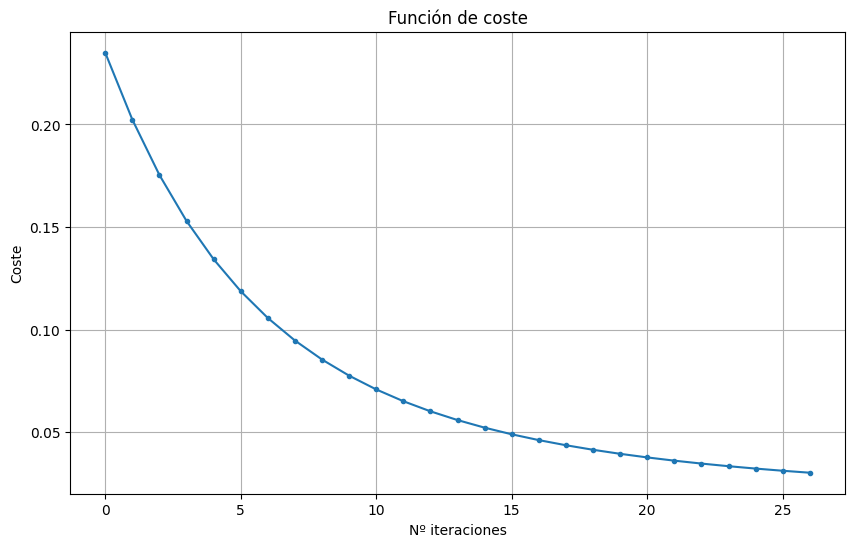

In [8]:
# TODO: Representa la evolución de la función de coste vs el nº de iteraciones

plt.figure(figsize=(10, 6))
plt.title('Función de coste')
plt.xlabel('Nº iteraciones')
plt.ylabel('Coste')

plt.plot(j_hist, marker='o', linestyle='-', markersize=3)
plt.grid()
plt.show()

Como decíamos antes, revisa el entrenamiento de tu modelo y modifica algún parámetro si es necesario para reentrenarlo, buscando que tenga un buen rendimiento: el ratio de aprendizaje, el punto de convergencia, el nº máx. de iteraciones, etc., excepto el parámetro de regularización *lambda*, que debe estar a 0.

*Nota*: Este punto es importante, puesto que por lo general, estos hiper-parámetros serán los mismos que utilizaremos para lo que resta de la optimización del modelo, por lo que ahora es el momento de encontrar los valores idóneos.

### Comprobar si existe desviación o sobreajuste, *bias* o *varianza*

Hay un test que podemos hacer rápidamente para comprobar si nuestro modelo inicial sufre claramente de desviación, varianza, o tiene un funcionamiento más o menos aceptable.

Vamos a representar gráficamente la evolución de la función de coste de 2 modelos, uno entrenado sobre los primeros *n* ejemplos del subset de entrenamiento y otro entrenado sobre los primeros *n* ejemplos del subset de validación.

Puesto que el subset de entrenamiento y el subset de validación no tienen el mismo tamaño, usa únicamente el mismo nº de ejemplos para este subset que ejemplos totales tenga el de validación.

Para ello entrena 2 modelos en igualdad de condiciones, copiando de nuevo las celdas de código correspondientes:

In [9]:
# TODO: Establece una theta_ini e hiper-parámetros comunes a ambos modelos, para entrenarlos en igualdad de condiciones

theta_ini = np.ones(X.shape[1]) * 0.2

alpha = 1e-1
lambda_ = 0.
e = 1e-3
iter_ =  int(1e2)

print('Hiper-arámetros usados:')
print('Alpha:', alpha, 'Error máx.:', e, 'Nº iter', iter_)


Hiper-arámetros usados:
Alpha: 0.1 Error máx.: 0.001 Nº iter 100


In [10]:
# TODO: Entrena un modelo sin regularización sobre los n primeros valores de X_train, donde n es el nº de
# ejemplos disponibles en X_val
# Usa j_hist_train y theta_train como nombres de variables para distinguirlos del otro modelo

n = X_val.shape[0]
X_train_subset = X_train[:n]
Y_train_subset = Y_train[:n]

j_hist_train, theta_train = regularized_gradient_descent(X_train_subset, Y_train_subset, theta_ini, alpha, lambda_=lambda_, e=e, iter_=iter_)


print("\nÚltimos 10 valores de la función de coste")
print(j_hist_train[-10:])
print("Coste final:")
print(j_hist_train[-1])
print("\nTheta final:")
print(theta_train)

print("Valores verdaderos de Theta y diferencia con valores entrenados:")
print(Theta_verd)
print(theta_train - Theta_verd)

Converge en la iteración nº 26

Últimos 10 valores de la función de coste
[0.04103471458798815, 0.038868061580961275, 0.03692989456983026, 0.03518942101107878, 0.0336208463187154, 0.03220247857976368, 0.030916000561814854, 0.029745877236380638, 0.028678873114445426, 0.027703658600152226]
Coste final:
0.027703658600152226

Theta final:
[0.7527423  0.33483472 0.47415387 0.41724354]
Valores verdaderos de Theta y diferencia con valores entrenados:
[0.79517739 0.42822674 0.60077786 0.59628616]
[-0.04243508 -0.09339202 -0.12662399 -0.17904262]


*Nota*: Comprueba que *theta_ini* no se ha modificado, o modifica tu código para que ambos modelos usen la misma *theta_ini*.

In [11]:
# TODO: Del mismo modo, entrena un modelo sin regularización sobre X_val con los mismos parámetros
# Recuerda usar j_hist_val y theta_val como nobmres de variables

j_hist_val, theta_val = regularized_gradient_descent(X_val, Y_val, theta_ini, alpha, lambda_=lambda_, e=e, iter_=iter_)


print("\nÚltimos 10 valores de la función de coste")
print(j_hist_val[-10:])
print("Coste final:")
print(j_hist_val[-1])
print("\nTheta final:")
print(theta_val)

print("Valores verdaderos de Theta y diferencia con valores entrenados:")
print(Theta_verd)
print(theta_val - Theta_verd)


Converge en la iteración nº 27

Últimos 10 valores de la función de coste
[0.03869408165113396, 0.03676424480849459, 0.035022043257855774, 0.03344350839350846, 0.03200847299717512, 0.03069989471925569, 0.02950330592326025, 0.02840636585558131, 0.027398495705983725, 0.02647058084377627]
Coste final:
0.02647058084377627

Theta final:
[0.74929974 0.33498635 0.46177189 0.41966265]
Valores verdaderos de Theta y diferencia con valores entrenados:
[0.79517739 0.42822674 0.60077786 0.59628616]
[-0.04587764 -0.09324038 -0.13900597 -0.17662351]


Ahora representa gráficamente ambas evoluciones sobre la misma gráfica, con colores diferentes, para poder compararlas:

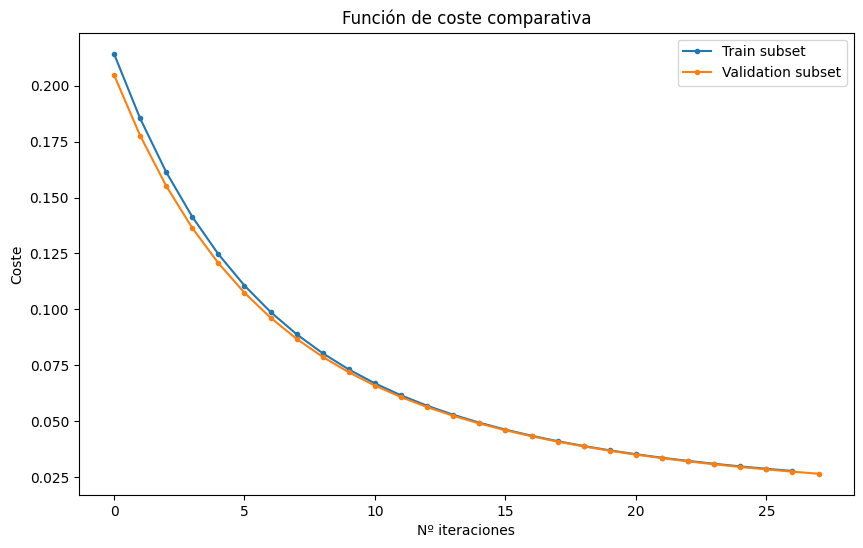

In [12]:
# TODO: Representa en una gráfica de líneas las evoluciones del coste en ambos datasets para compararlas

plt.figure(figsize=(10, 6))
plt.plot(j_hist_train, label='Train subset', marker='o', linestyle='-', markersize=3)
plt.plot(j_hist_val, label='Validation subset', marker='o', linestyle='-', markersize=3)
plt.title('Función de coste comparativa')
plt.xlabel('Nº iteraciones')
plt.ylabel('Coste')
plt.legend()
plt.show()

Con un dataset sintético aleatorio es difícil que se diera sobre-ajuste, ya que los datos originales seguirán el mismo patrón, pero de esta forma podríamos apreciar dichos problemas de la siguiente forma:

- Si el coste final en ambos subsets es alto, puede haber un problema de desviación o *bias*.
- Si el coste final en ambos subsets es muy diferente entre sí, puede haber un problema de sobreajuste o *varianza*, especialmente cuando el coste en el subset de entrenamiento es bastante inferior a en el subset de validación,

Recordamos qué significaban la desviación y sobre-ajuste:
- La desviación se produce cuando el modelo no puede ajustar suficientemente bien la curva del dataset, sea porque no son las características correctas (o faltarían otras), sea porque los datos tienen demasiado error, o sea porque el modelo sigue una relación distinta o sea demasiado simple.
- El sobreajuste se produce cuando el modelo ajusta muy bien la curva del dataset, demasiado bien, demasiado ajustada a los ejemplos sobre los que se ha entrenado, y cuando tiene que predecir sobre nuevos resultados no lo hace correctamente.

### Comprobar la idoneidad del modelo

Como decíamos, otra razón para entrenar un modelo inicial es comprobar si tiene sentido entrenar un modelo de regresión lineal multivariable sobre dicho dataset.

Si vemos que el modelo sufre de sobreajuste, siempre podemos corregirla con la regularización. Sin embargo, si vemos que sufre de una alta desviación, i.e. que el coste final es muy alto, puede que nuestro tipo de modelo o las características escogidas no sean idóneas para este problema.

En este caso, hemos comprobado que el error es suficientemente bajo para que resulte prometedor continuar entrenando dicho modelo de regresión lineal multivariable.

## Hallar el hiper-parámetro *lambda* óptimo sobre el subset de validación

Ahora, para conseguir hallar la *lambda* óptima, vamos a entrenar un modelo diferente por cada valor de *lambda* a considerar, sobre el subset de entrenamiento, y comprobar su precisión sobre el subset de validación.

Vamos a representar gráficamente el error o coste final de cada modelo vs el valor de *lambda* usado, para ver qué modelo tiene un error o coste menor en el subset de validación.

De esta forma, entrenamos todos los modelos sobre el mismo subset y en igualdad de condiciones (excepto *lambda*), y los evaluamos en un subset de datos que no han visto previamente, que no hemos usado para entrenarlos.

El subset de validación, por tanto, no se usa para entrenar el modelo, sino sólo para evaluar el valor de *lambda* óptimo. Excepto en el punto anterior, donde hemos hecho una evaluación inicial rápida sobre la posible aparición de sobreajuste.

In [13]:
# TODO: Entrena un modelo por cada valor de lambda diferente sobre X_train y evalúalo sobre X_val

lambdas = [0., 1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1, 1e0, 3e0, 1e1]
# BONUS: Genera un array de lambdas con 10 valores en una escala logarítmica entre 10^-3 y 10, alternando entre valores cuyo primer decimal no-cero es un 1 y un 3, como esta lista

# Completa el código para entrenar un modelo diferente para cada valor de lambda sobre X_train
# Almacena su theta y error/coste final
# Posteriormente, evalúa su coste total en el subset de validación

# Almacena dicha información en los siguientes arrays, del mismo tamaño que el de lambdas
j_train = np.zeros(len(lambdas))
j_val = np.zeros(len(lambdas))
theta_val = np.zeros((len(lambdas), X_train.shape[1]))

alpha = 0.1
e = 1e-3
iter_ = 1000

for i, lam in enumerate(lambdas):
    j_hist, theta_final = regularized_gradient_descent(X_train, Y_train, theta_ini, alpha, lambda_=lam, e=e, iter_=iter_)

    j_train[i] = j_hist[-1]
    theta_val[i] = theta_final

    Y_val_pred = X_val @ theta_final
    j_val[i] = np.mean((Y_val - Y_val_pred)**2)  # coste MSE




Converge en la iteración nº 26
Converge en la iteración nº 26
Converge en la iteración nº 26
Converge en la iteración nº 26
Converge en la iteración nº 26
Converge en la iteración nº 26
Converge en la iteración nº 26
Converge en la iteración nº 26
Converge en la iteración nº 26
Converge en la iteración nº 25


Una vez entrenados todos los modelos, representa en una gráfica de líneas su coste final sobre el subset de entrenamiento y el coste final sobre el de validación vs el valor de *lambda* utilizado:

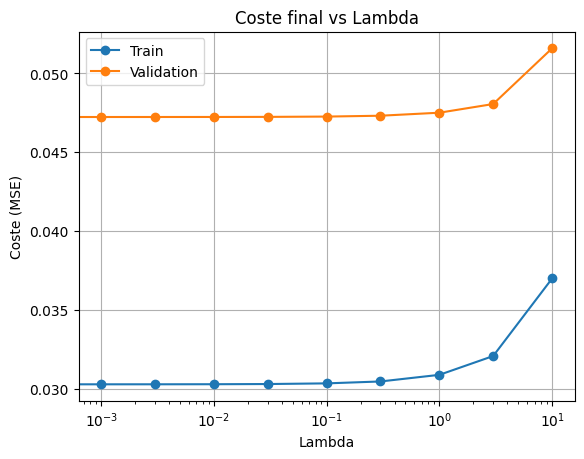

In [14]:
# TODO: Representa gráficamente el error final para cada valor de lambda


plt.plot(lambdas, j_train, marker='o', linestyle='-', label='Train')

# Graficar coste de validación
plt.plot(lambdas, j_val, marker='o', linestyle='-', label='Validation')


plt.xscale('log')

plt.xlabel('Lambda')
plt.ylabel('Coste (MSE)')
plt.title('Coste final vs Lambda')
plt.legend()
plt.grid(True)
plt.show()

Una vez representados dichos errores finales, podríamos elegir automáticamente el modelo con el valor de *lambda* óptimo:

In [15]:
# TODO: Escoge el modelo y el valor de lambda óptimos, con el menor error sobre el subset de validación

# Itera sobre la  theta y lambda de todos los modelos y escoge el de menor coste en el subset de validación

theta_final = theta_val[np.argmin(j_val)]
lambda_final = lambdas[np.argmin(j_val)]
j_final = j_val[np.argmin(j_val)]

print(lambda_final)
print(j_final)
print(theta_final)


0.0
0.04722421942594961
[0.77357067 0.35054177 0.47631803 0.43722432]


Una vez implementados todos los pasos anteriores, tenemos nuestro modelo entrenado y sus hiper-parámetros optimizados.

## Evaluar el modelo finalmente sobre el subset de test

Finalmente, hemos encontrado nuestros coeficientes *theta* e hiper-parámetro *lambda* óptimos, por lo que ya disponemos de un modelo entrenado y listo para ser usado.

Sin embargo, aunque hemos calculado su error o coste final sobre el subset de validación, hemos usado dicho subset para escoger el modelo o para "terminar de entrenarlo". Por tanto, no hemos comprobado todavía cómo funcionará este modelo sobre datos que no ha visto nunca antes.

Para ello, vamos a evaluarlo finalmente sobre el subset de test, sobre un subset que no hemos utilizado aún ni para entrenar el modelo ni para escoger sus hiper-parámetros. Un subset separado que el entrenamiento del modelo no ha visto aún.

Por tanto, vamos a calcular el error o coste total sobre el subset de test y comprobar gráficamente los residuos del modelo sobre el mismo:

In [16]:
# TODO: Calcula el error del modelo sobre el subset de test usando la función de coste con las correspondientes
# theta y lambda

j_test = regularized_cost_function(X_test, Y_test, theta_final, lambda_final)
print(f"Coste: {j_test}")

Coste: 0.03309444106403078


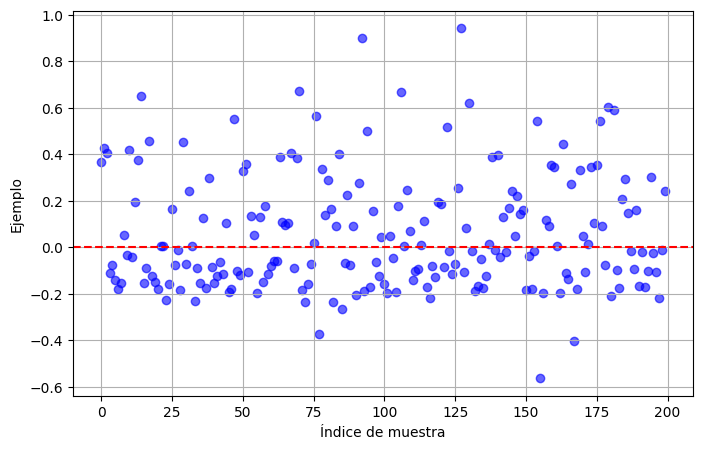

In [17]:
# TODO: Calcula las predicciones del modelo sobre el subset de test, sus resíduos y represéntalos

Y_test_pred = X_test @ theta_final

residuos = Y_test - Y_test_pred

plt.figure(figsize=(8,5))
plt.scatter(range(len(residuos)), residuos, color='blue', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Índice de muestra')
plt.ylabel('Ejemplo')
plt.grid(True)
plt.show()

plt.show()

De esta forma podemos hacernos una idea más real sobre la precisión de nuestro modelo y cómo se comportará con nuevos ejemplos en el futuro.

## Preprocesamiento de datos con Scikit-learn

Para acabar, busca y utiliza las funciones disponibles en Scikit-learn para preprocesar los datos:
1. [Reordenando aleatoriamente](https://scikit-learn.org/stable/modules/generated/sklearn.utils.shuffle.html?highlight=shuffle#sklearn.utils.shuffle)
1. [Normalizando/escalando](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling)
1. [Dividiendo los datos en los 3 subsets correspondientes](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html?highlight=split#sklearn.model_selection.train_test_split)

In [18]:
# TODO: Utiliza las funciones de Scikit-learn para reordenar aleatoriamente, normalizar y dividir los datos en los subsets de entrenamiento, validación y test
# Utiliza la X original en lugar de X_norm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_reord = shuffle(X, random_state=42)
Y_reord = Y[shuffle(np.arange(len(Y)), random_state=42)]
scaler = StandardScaler()
X_reord[:, 1:] = scaler.fit_transform(X_reord[:, 1:])
X_escalada = X_reord

X_train, X_temp, Y_train, Y_temp = train_test_split(X_escalada, Y_reord, test_size=0.4, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

